### Cleaning and Feature Selection

In [1]:
# Warnings are provided to warn the developer of situations that aren’t necessarily exceptions. 
#Usually, a warning occurs when there is some obsolete of certain programming elements.
#Python program terminates immediately if an error occurs. Conversely, a warning is not critical.

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
kick_data = pd.read_csv('ConcatenatedResults/concatenated_results_kick.csv')

normal_data = pd.read_csv('ConcatenatedResults/concatenated_results_normal.csv')

validation_data = pd.read_csv('ConcatenatedResults/results_influx_validation_2023-03-27_12-48-45.csv')

df_validation = validation_data

### Splitting the data by Method 2, 70/10/20

In [4]:
def split_data_by_sim_id(df, test_size=0.2, val_size=0.1, random_state=42):
   sim_ids = df['sim_ID'].unique()
   train_sim_ids, test_val_sim_ids = train_test_split(sim_ids, test_size=test_size+val_size, random_state=random_state)
   test_sim_ids, val_sim_ids = train_test_split(test_val_sim_ids, test_size=test_size/(test_size+val_size), random_state=random_state)

   train_data = df[df['sim_ID'].isin(train_sim_ids)]
   val_data = df[df['sim_ID'].isin(val_sim_ids)]
   test_data = df[df['sim_ID'].isin(test_sim_ids)]

   return train_data, val_data, test_data

kick_train, kick_val, kick_test = split_data_by_sim_id(kick_data)
normal_train, normal_val, normal_test = split_data_by_sim_id(normal_data)

#Concatenate the resulting train, validation, and test sets
df_train = pd.concat([kick_train, normal_train], ignore_index=True)
df_val = pd.concat([kick_val, normal_val], ignore_index=True)
df_test = pd.concat([kick_test, normal_test], ignore_index=True)

### Removing constant columns

In [5]:
# Drop columns with non-float64 data type
df_train_original = df_train.select_dtypes(include=['float64', 'int64'])
df_val_original = df_val.select_dtypes(include=['float64', 'int64'])
df_test_original = df_test.select_dtypes(include=['float64', 'int64'])
df_validation_original = df_validation.select_dtypes(include=['float64', 'int64'])

df_train = df_train_original.drop(['sim_ID'], axis=1)
df_val = df_val_original.drop(['sim_ID'], axis=1)
df_test = df_test_original.drop(['sim_ID'], axis=1)
df_validation = df_validation_original.drop(['sim_ID'], axis=1)

In [6]:
def remove_unique_columns(df):
    for column in df.columns:
        if column not in ['GasFlowRateOut', 'TotalInfluxMass'] and df[column].nunique() == 1:
            df = df.drop(column, axis=1)
    return df

# Remove unique columns from df_train
df_train = remove_unique_columns(df_train)

df_val = remove_unique_columns(df_val)

df_test = remove_unique_columns(df_test)

# Remove unique columns from df_validation
df_validation = remove_unique_columns(df_validation)

In [7]:
df_train.nunique()

SPP                             218799
DownholeECD                     218854
FlowRateOut                     218925
HookLoad                        218994
SurfaceTorque                   217415
BitDepth                        123355
DownholePressure                218854
FluidTemperatureOut             218948
WOB                             124339
InstantaneousROP                 96683
FlowRateIn                         383
TopOfStringVelocity                 20
SurfaceRPM                         203
TotalInfluxMass                   8154
CalculatedPressureBottomHole    218854
FluidTemperatureIn              158887
TopOfStringPosition                600
ActivePitVolume                 215403
ActivePitDensity                158624
ActivePitTemperature            158887
MainPitVolume                   215403
MainPitDensity                  158624
MainPitTemperature              158887
GasFlowRateOut                   76847
timeStep                           600
dtype: int64

### Scaling using the MinMaxScaler before Heatmap

In [8]:
# Initialize the scalers
minmax_scaler = MinMaxScaler()

# Fit and transform the data using both scalers
minmax_scaled_data = minmax_scaler.fit_transform(df_train)

# Create DataFrames with the scaled data
minmax_scaled_df = pd.DataFrame(minmax_scaled_data, columns=df_train.columns)

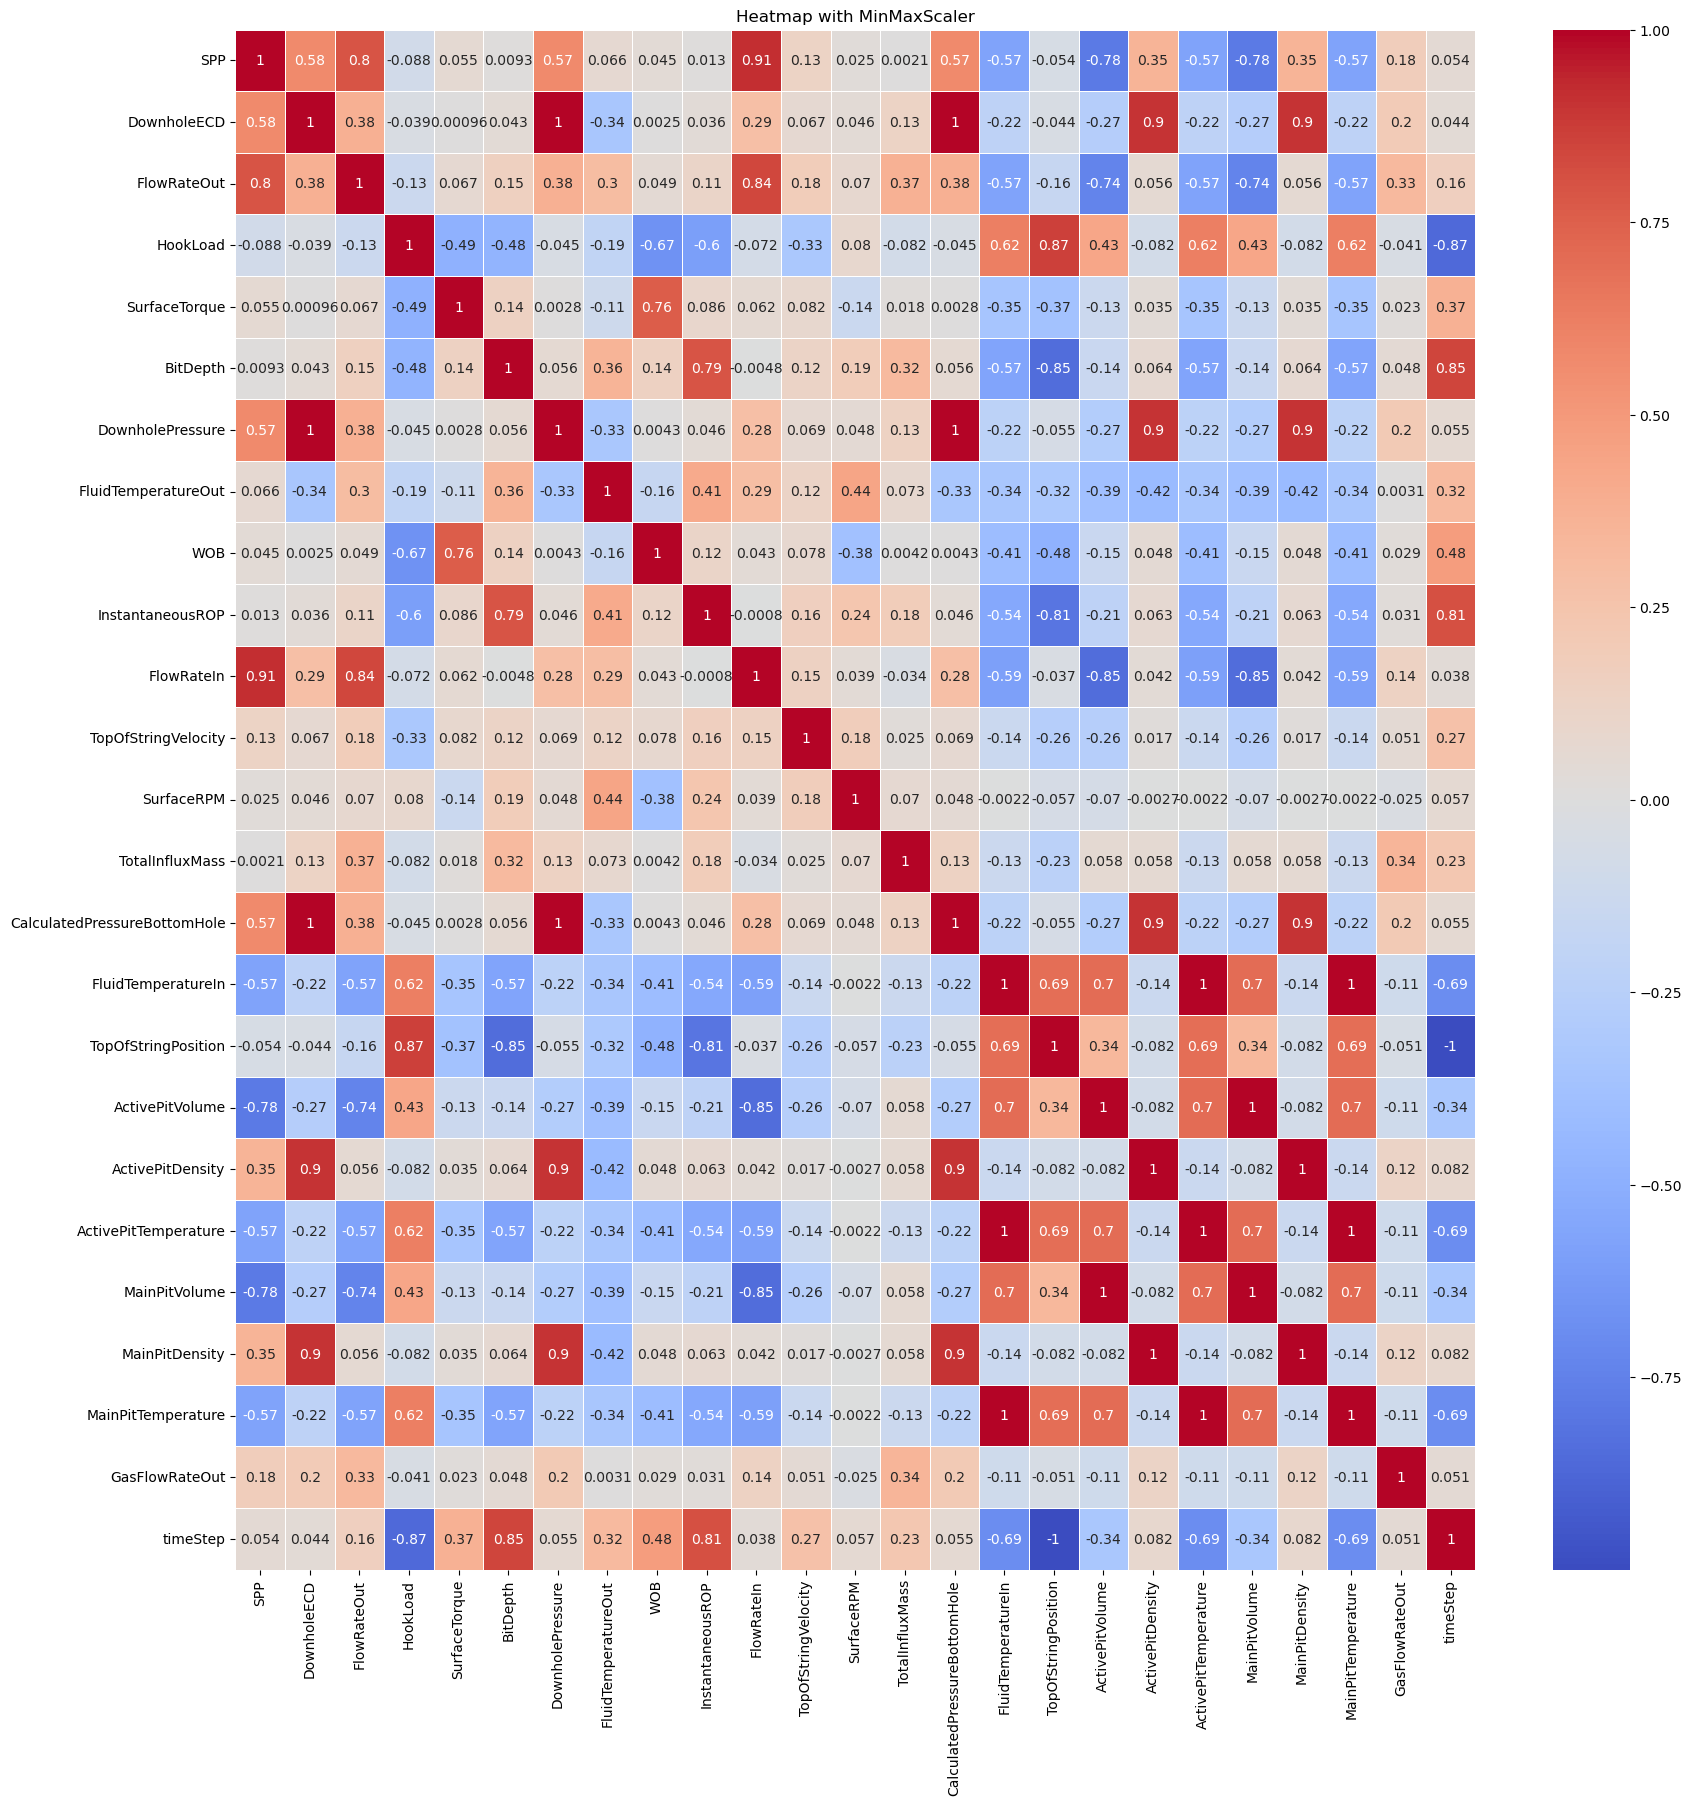

In [9]:
# Plot the heatmap for MinMaxScaler
plt.figure(figsize=(20, 20))
plt.title("Heatmap with MinMaxScaler")
sns.heatmap(minmax_scaled_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

### Removing features which are not relevant

In [10]:
# Assuming 'unwanted_features' is a list of column names you want to drop after feature selection
unwanted_features = ['GasFlowRateOut', 'TotalInfluxMass','TopOfStringPosition', 'MainPitTemperature', 'ActivePitVolume', 'ActivePitTemperature', 'ActivePitDensity', 'CalculatedPressureBottomHole', 'DownholeECD', 'TopOfStringVelocity']

# Unscaled the data using inverse_transform
unscaled_data = minmax_scaler.inverse_transform(minmax_scaled_df)

# Create a DataFrame with the unscaled data
unscaled_df = pd.DataFrame(unscaled_data, columns=df_train.columns)

# Drop the unwanted features
selected_features_df = unscaled_df.drop(columns=unwanted_features)

minmax_scaled_data_selected = minmax_scaler.fit_transform(selected_features_df)

# Create a DataFrame with the selected and scaled data
minmax_scaled_df_selected = pd.DataFrame(minmax_scaled_data_selected, columns=selected_features_df.columns)

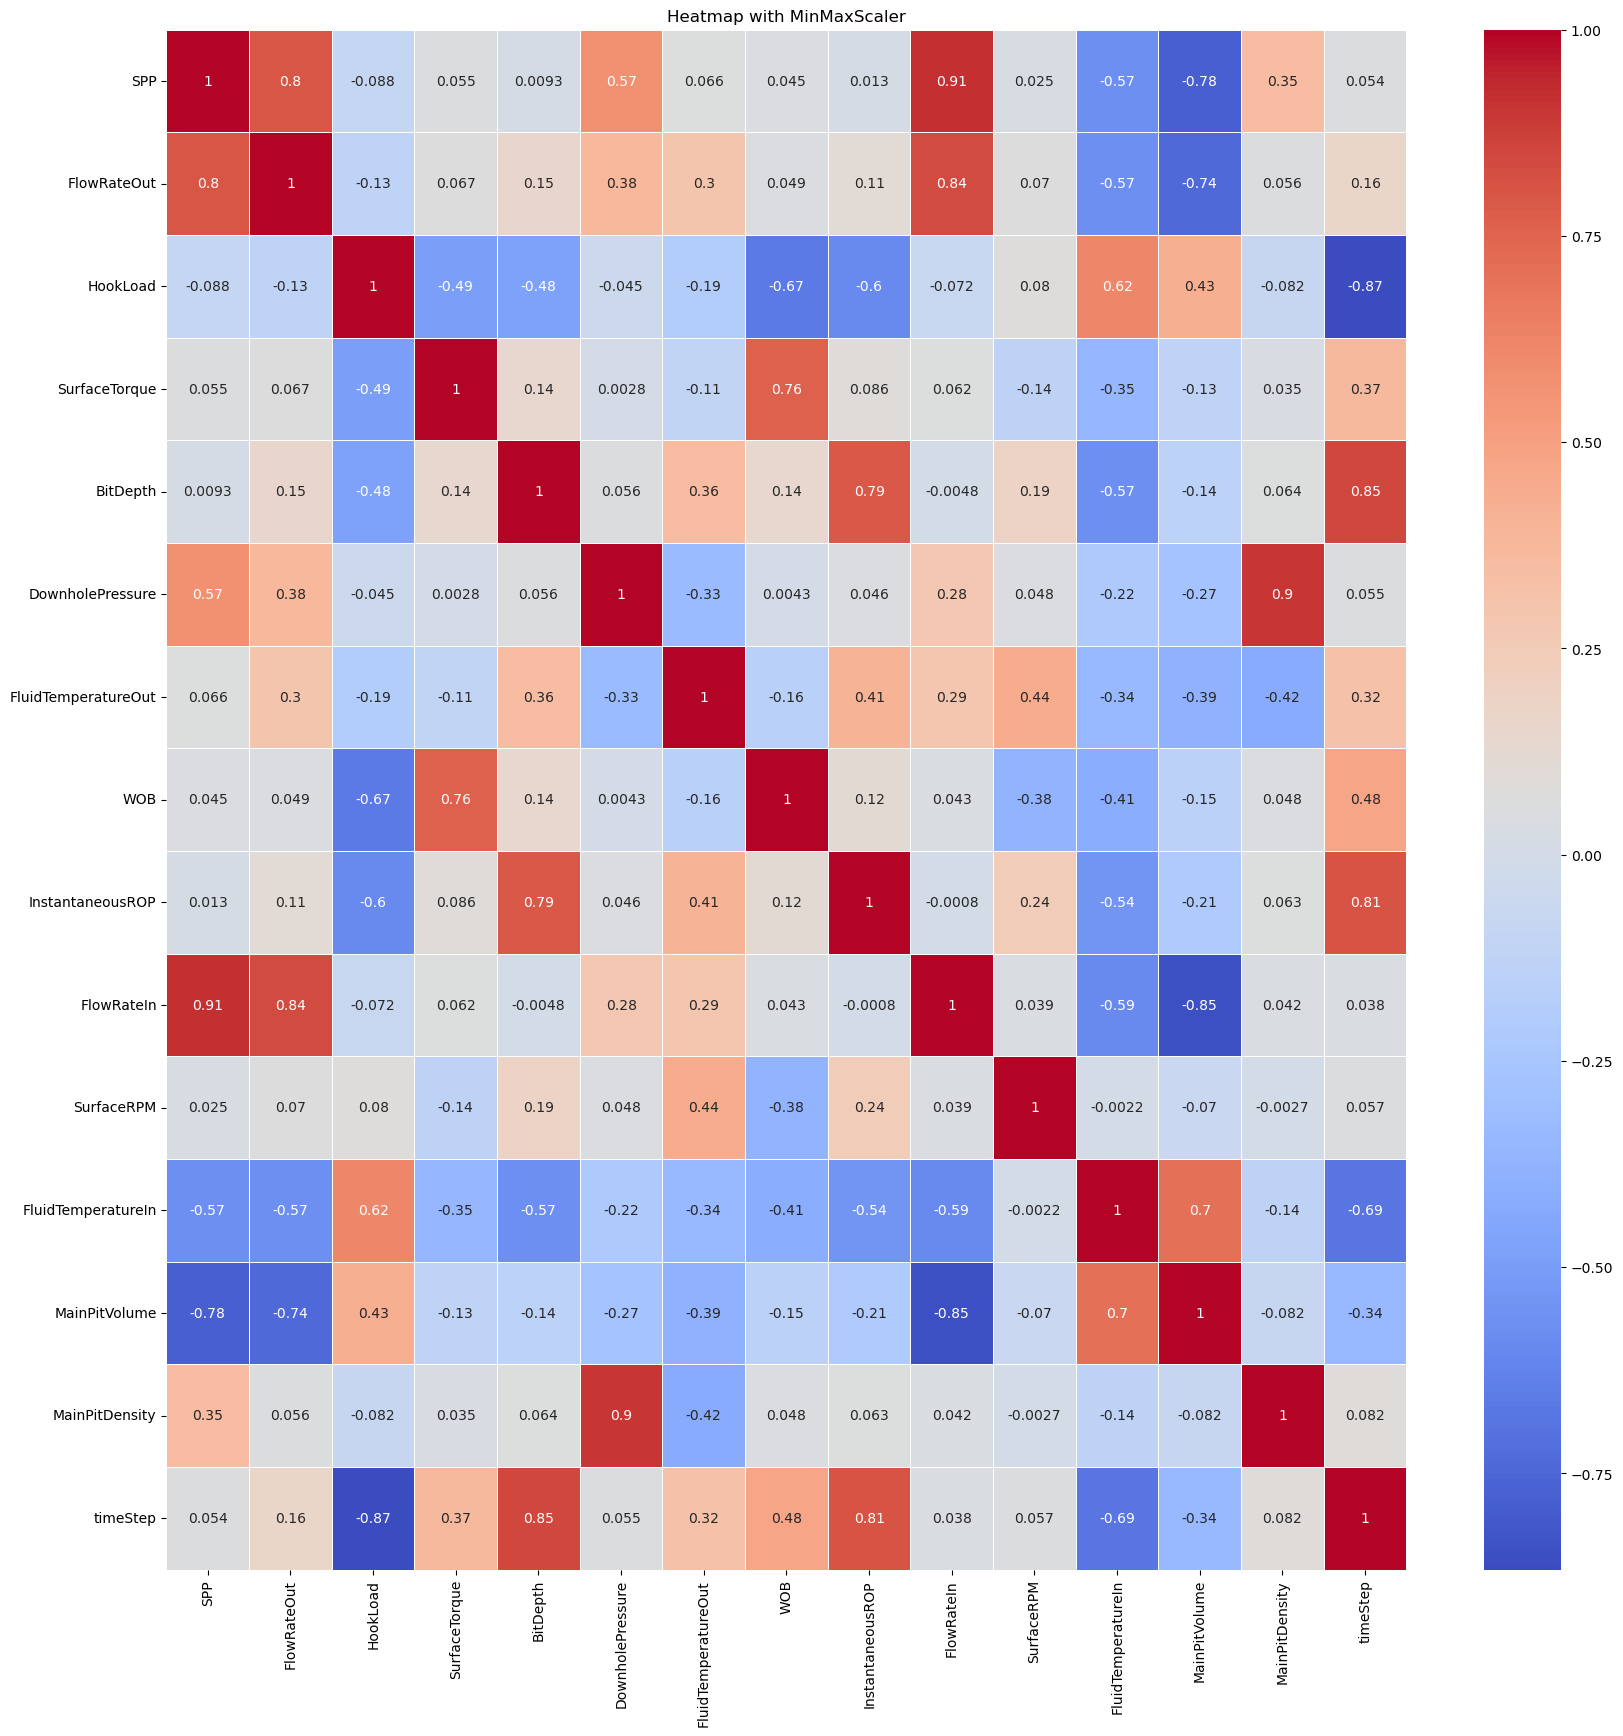

In [11]:
# Plot the heatmap for MinMaxScaler
plt.figure(figsize=(20, 20))
plt.title("Heatmap with MinMaxScaler")
sns.heatmap(minmax_scaled_df_selected.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

### Removing unwanted features and scaling the other dataframes aswell

In [12]:
df_train2 = minmax_scaled_df_selected

In [13]:
df_vali = df_validation.drop(columns=unwanted_features)

scaled_data_validation = minmax_scaler.fit_transform(df_vali)

scaled_data_validation = pd.DataFrame(scaled_data_validation, columns=df_vali.columns)

df_validation2 = scaled_data_validation

In [14]:
# Drop the unwanted columns from df_test, excluding the 'TopOfStringVelocity' column
df_test1 = df_test.drop(columns=[col for col in unwanted_features])

# Scale the remaining columns using MinMaxScaler
scaled_data_test = minmax_scaler.fit_transform(df_test1)

# Create a new dataframe from the scaled data and use the column names from df_test1
scaled_data_test = pd.DataFrame(scaled_data_test, columns=df_test1.columns)

# Assign the new dataframe to df_test
df_test2 = scaled_data_test

In [15]:
# Drop the unwanted columns from df_test, excluding the 'TopOfStringVelocity' column
df_val1 = df_val.drop(columns=[col for col in unwanted_features])

# Scale the remaining columns using MinMaxScaler
scaled_data_val = minmax_scaler.fit_transform(df_val1)

# Create a new dataframe from the scaled data and use the column names from df_test1
scaled_data_val = pd.DataFrame(scaled_data_val, columns=df_val1.columns)

# Assign the new dataframe to df_test
df_val2 = scaled_data_val

### Storing the datasets, scaler and input/target column in the notebook for further ML in anoter notebook

In [16]:
# Store the DataFrame in the IPython database
%store df_train2
%store df_val2
%store df_test2
%store df_validation2

Stored 'df_train2' (DataFrame)
Stored 'df_val2' (DataFrame)
Stored 'df_test2' (DataFrame)
Stored 'df_validation2' (DataFrame)


In [17]:
# create a list of column names to include in the new DataFrame
input_col2 = [col for col in df_train2.columns if col != 'DownholePressure']

target_col2 = ['DownholePressure']

%store input_col2
%store target_col2

Stored 'input_col2' (list)
Stored 'target_col2' (list)


In [18]:
minmax_scaler2 = minmax_scaler
%store minmax_scaler2

Stored 'minmax_scaler2' (MinMaxScaler)


In [19]:
# Split df_train into x_train and y_train
x_train = df_train2[input_col2]
y_train = df_train2[target_col2]

x_val = df_val2[input_col2]
y_val = df_val2[target_col2]

# Split the testing data
x_test = df_test2[input_col2]
y_test = df_test2[target_col2]

#Split the validation data
x_validation = df_validation2[input_col2]
y_validation = df_validation2[target_col2]

### Plots to see how the features look against timesteps for split method 2

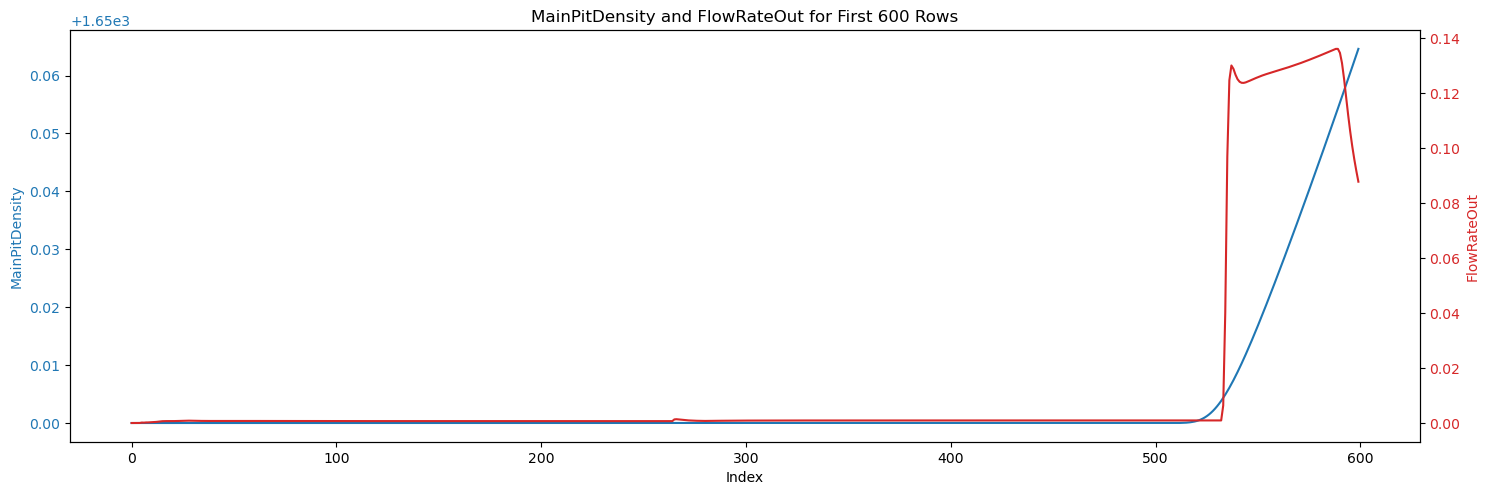

In [20]:
# Assuming df_train is your train_data DataFrame
df_plot = df_train.head(600)

fig, ax1 = plt.subplots(figsize=(15, 5))  # Adjust the figsize here (width, height)

# Plot MainPitDensity with a blue color
color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('MainPitDensity', color=color)
ax1.plot(df_plot.index, df_plot['MainPitDensity'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot FlowRateOut with a red color
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('FlowRateOut', color=color)
ax2.plot(df_plot.index, df_plot['FlowRateOut'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('MainPitDensity and FlowRateOut for First 600 Rows')
plt.show()

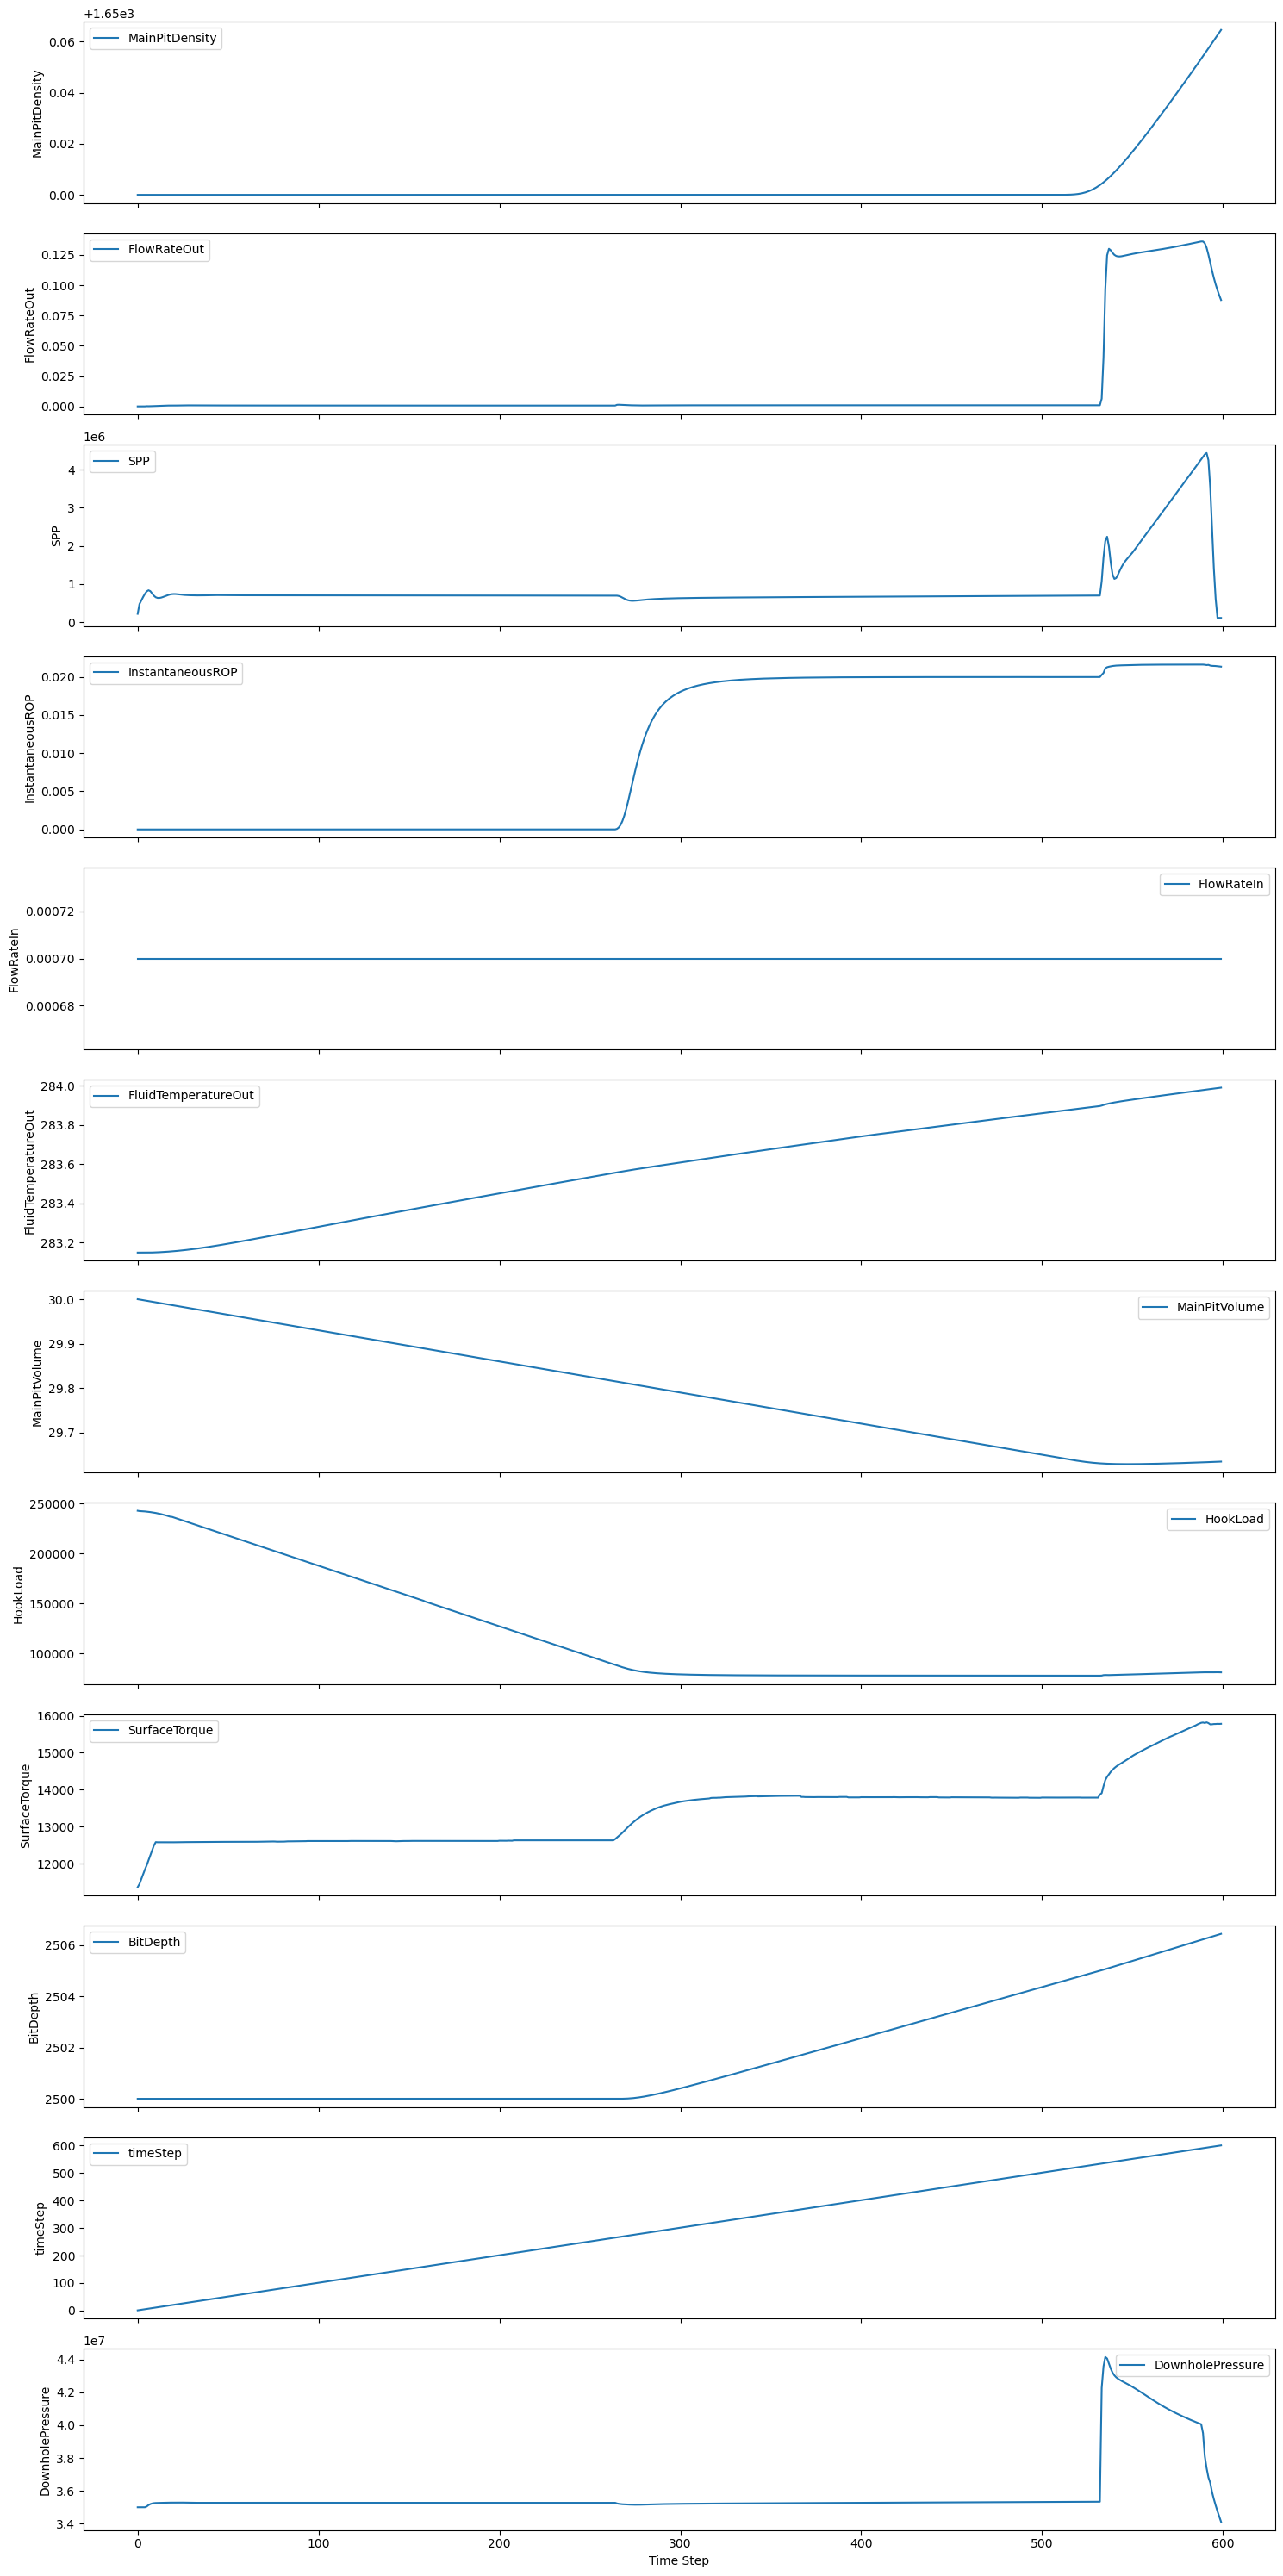

In [21]:
features = [
    "MainPitDensity",
    "FlowRateOut",
    "SPP",
    "InstantaneousROP",
    "FlowRateIn",
    "FluidTemperatureOut",
    "MainPitVolume",
    "HookLoad",
    "SurfaceTorque",
    "BitDepth",
    "timeStep", 
    "DownholePressure"
]

# Assuming df_train is your training DataFrame
plot_data = df_train.head(600)

fig, axs = plt.subplots(len(features), figsize=(15, 30), sharex=True)

for i, feature in enumerate(features):
    axs[i].plot(plot_data[feature], label=feature)
    axs[i].set_ylabel(feature)
    axs[i].legend()

plt.xlabel('Time Step')
plt.tight_layout()
plt.show()